<a href="https://colab.research.google.com/github/estoymukundjha/Energy-Application-Prediction/blob/main/Appliance_Energy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import datetime as dt
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

In [2]:
data = pd.read_csv("/content/drive/MyDrive/Data/data_application_energy.csv")

In [3]:
df = pd.DataFrame(data)

##Understanding the data

In [4]:
df.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [5]:
df.shape

(19735, 29)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         19735 non-null  object 
 1   Appliances   19735 non-null  int64  
 2   lights       19735 non-null  int64  
 3   T1           19735 non-null  float64
 4   RH_1         19735 non-null  float64
 5   T2           19735 non-null  float64
 6   RH_2         19735 non-null  float64
 7   T3           19735 non-null  float64
 8   RH_3         19735 non-null  float64
 9   T4           19735 non-null  float64
 10  RH_4         19735 non-null  float64
 11  T5           19735 non-null  float64
 12  RH_5         19735 non-null  float64
 13  T6           19735 non-null  float64
 14  RH_6         19735 non-null  float64
 15  T7           19735 non-null  float64
 16  RH_7         19735 non-null  float64
 17  T8           19735 non-null  float64
 18  RH_8         19735 non-null  float64
 19  T9  

In [7]:
df.isna().sum()

date           0
Appliances     0
lights         0
T1             0
RH_1           0
T2             0
RH_2           0
T3             0
RH_3           0
T4             0
RH_4           0
T5             0
RH_5           0
T6             0
RH_6           0
T7             0
RH_7           0
T8             0
RH_8           0
T9             0
RH_9           0
T_out          0
Press_mm_hg    0
RH_out         0
Windspeed      0
Visibility     0
Tdewpoint      0
rv1            0
rv2            0
dtype: int64

In [8]:
#Checking for duplicates
duplicate_df = df[df.duplicated()]
duplicate_df

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2


In [9]:
df.describe(include='all')

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
count,19735,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
unique,19735,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2016-01-15 13:40:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,97.694958,3.801875,21.686571,40.259739,20.341219,40.420420,22.267611,39.242500,20.855335,39.026904,19.592106,50.949283,7.910939,54.609083,20.267106,35.388200,22.029107,42.936165,19.485828,41.552401,7.411665,755.522602,79.750418,4.039752,38.330834,3.760707,24.988033,24.988033
std,NaN,102.524891,7.935988,1.606066,3.979299,2.192974,4.069813,2.006111,3.254576,2.042884,4.341321,1.844623,9.022034,6.090347,31.149806,2.109993,5.114208,1.956162,5.224361,2.014712,4.151497,5.317409,7.399441,14.901088,2.451221,11.794719,4.194648,14.496634,14.496634
min,NaN,10.000000,0.000000,16.790000,27.023333,16.100000,20.463333,17.200000,28.766667,15.100000,27.660000,15.330000,29.815000,-6.065000,1.000000,15.390000,23.200000,16.306667,29.600000,14.890000,29.166667,-5.000000,729.300000,24.000000,0.000000,1.000000,-6.600000,0.005322,0.005322
25%,NaN,50.000000,0.000000,20.760000,37.333333,18.790000,37.900000,20.790000,36.900000,19.530000,35.530000,18.277500,45.400000,3.626667,30.025000,18.700000,31.500000,20.790000,39.066667,18.000000,38.500000,3.666667,750.933333,70.333333,2.000000,29.000000,0.900000,12.497889,12.497889
50%,NaN,60.000000,0.000000,21.600000,39.656667,20.000000,40.500000,22.100000,38.530000,20.666667,38.400000,19.390000,49.090000,7.300000,55.290000,20.033333,34.863333,22.100000,42.375000,19.390000,40.900000,6.916667,756.100000,83.666667,3.666667,40.000000,3.433333,24.897653,24.897653
75%,NaN,100.000000,0.000000,22.600000,43.066667,21.500000,43.260000,23.290000,41.760000,22.100000,42.156667,20.619643,53.663333,11.256000,83.226667,21.600000,39.000000,23.390000,46.536000,20.600000,44.338095,10.408333,760.933333,91.666667,5.500000,40.000000,6.566667,37.583769,37.583769


####Seprating different columns

In [10]:
temperature = df[["T1","T2","T3","T4","T5","T6","T7","T8","T9"]]

weather = df[["T_out", "Tdewpoint","RH_out","Press_mm_hg", "Windspeed","Visibility"] ]

light = df[["lights"]]

humidity = df[["RH_1","RH_2","RH_3","RH_4","RH_5","RH_6","RH_7","RH_8","RH_9"]]

randoms = df[["rv1", "rv2"]]

date = df['date']

X = df.drop(labels=['Appliances','date'], axis = 1)
Y = df["Appliances"]

#Exploratory DAta Analysis

####Univariate

In [11]:
dataVisual = df.drop(['rv1', 'rv2'], axis=1)

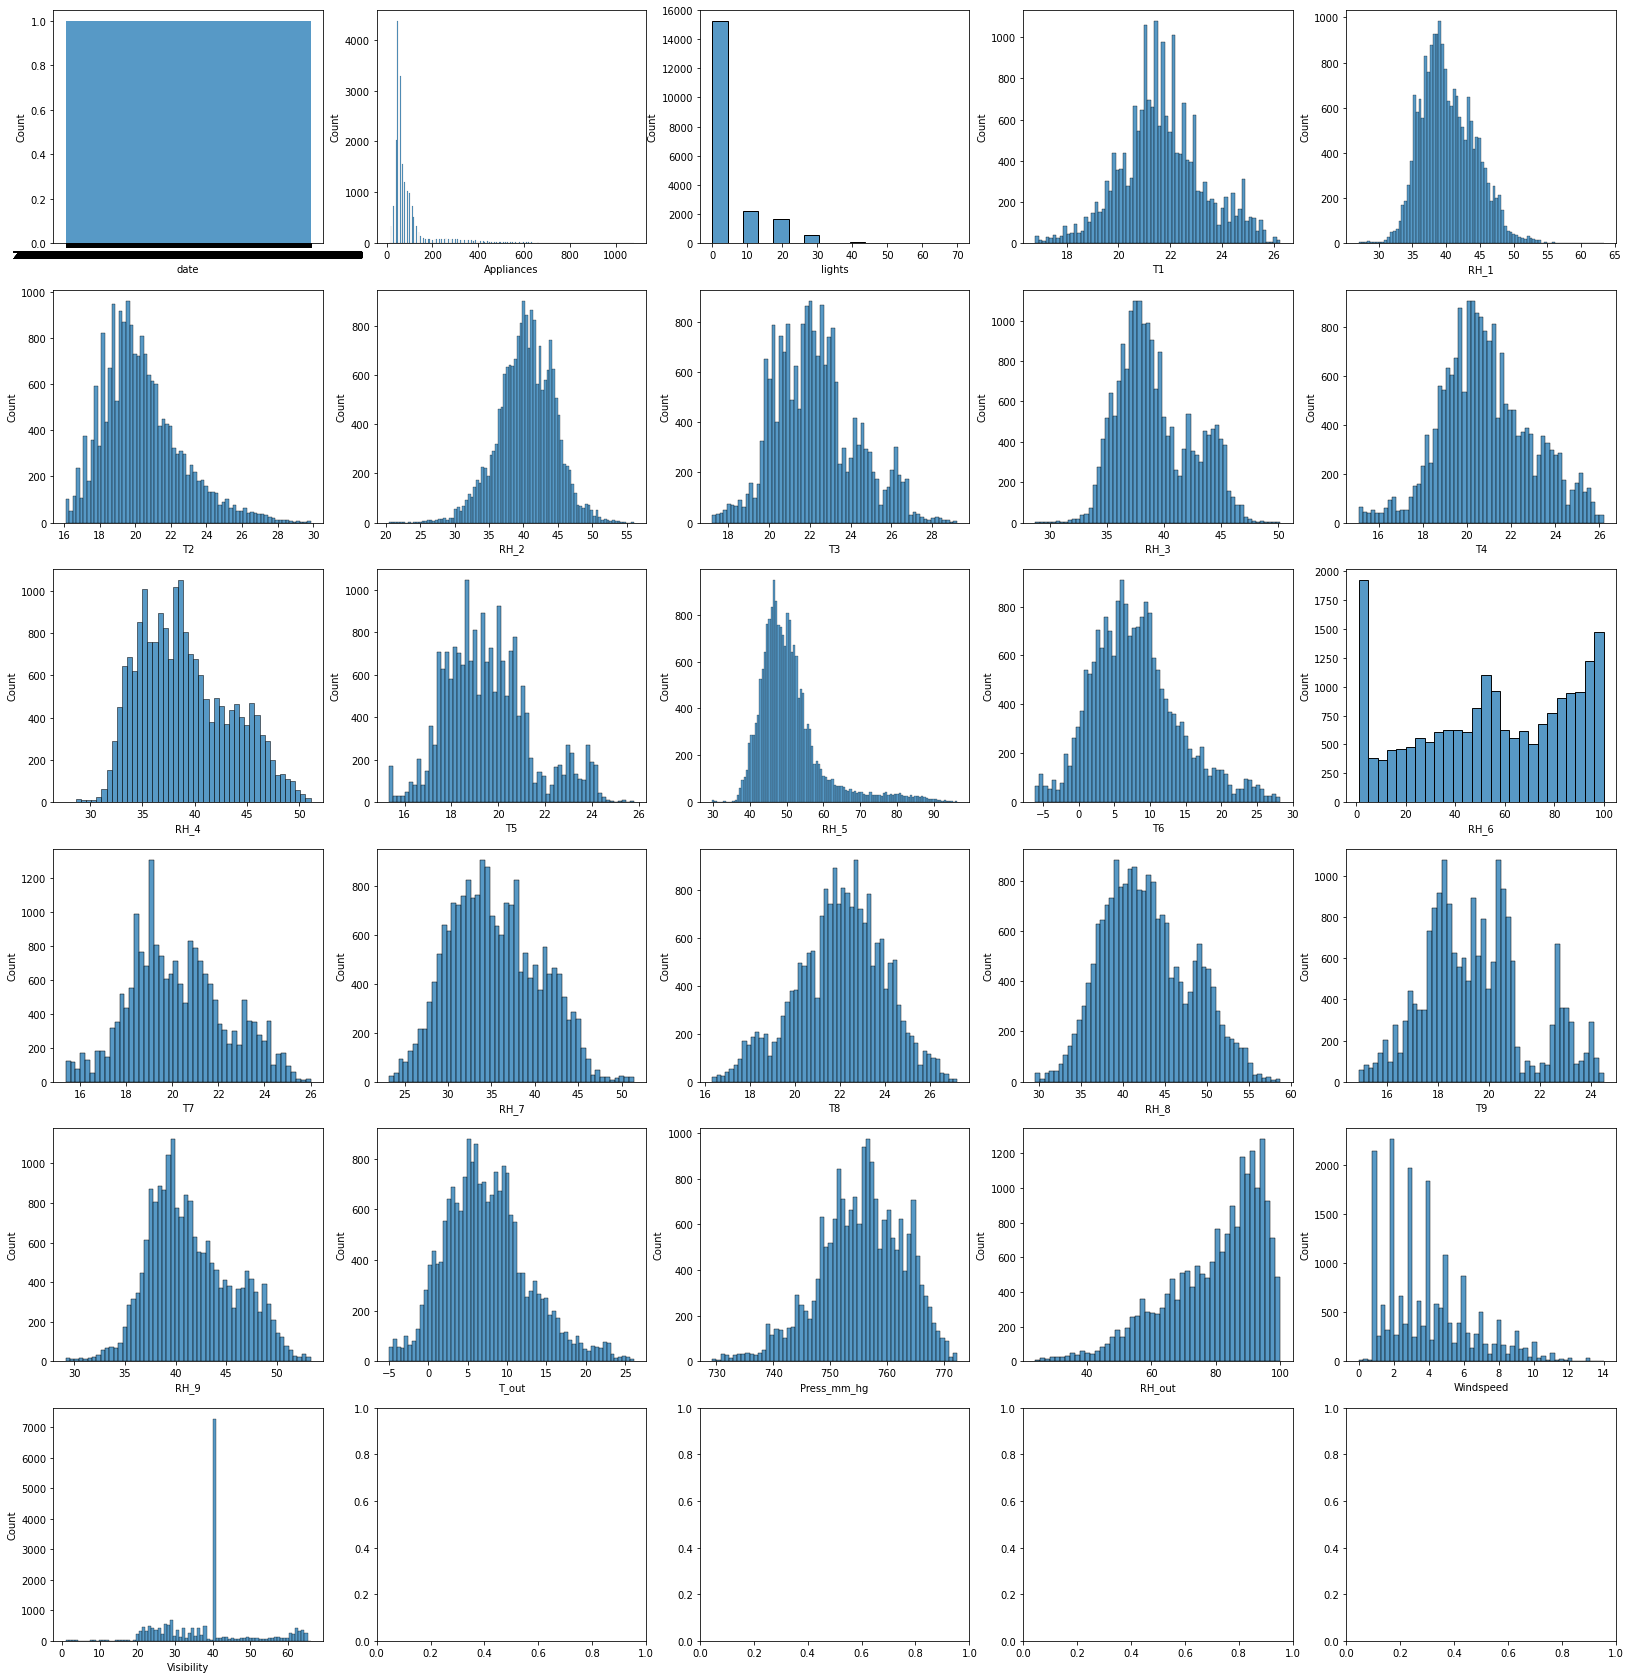

In [12]:
# Distribution plot for each features

ls = []
colName = [j for j in dataVisual.columns]
a = 0
while a < 7:
    for i in range(5):
        ls.append((a, i))
    a+=1
fig, ax = plt.subplots(6, 5, figsize=(28, 30))
for k in range(26):
    sns.histplot(ax=ax[ls[k][0], ls[k][1]], x=colName[k], data=dataVisual)

TypeError: ignored

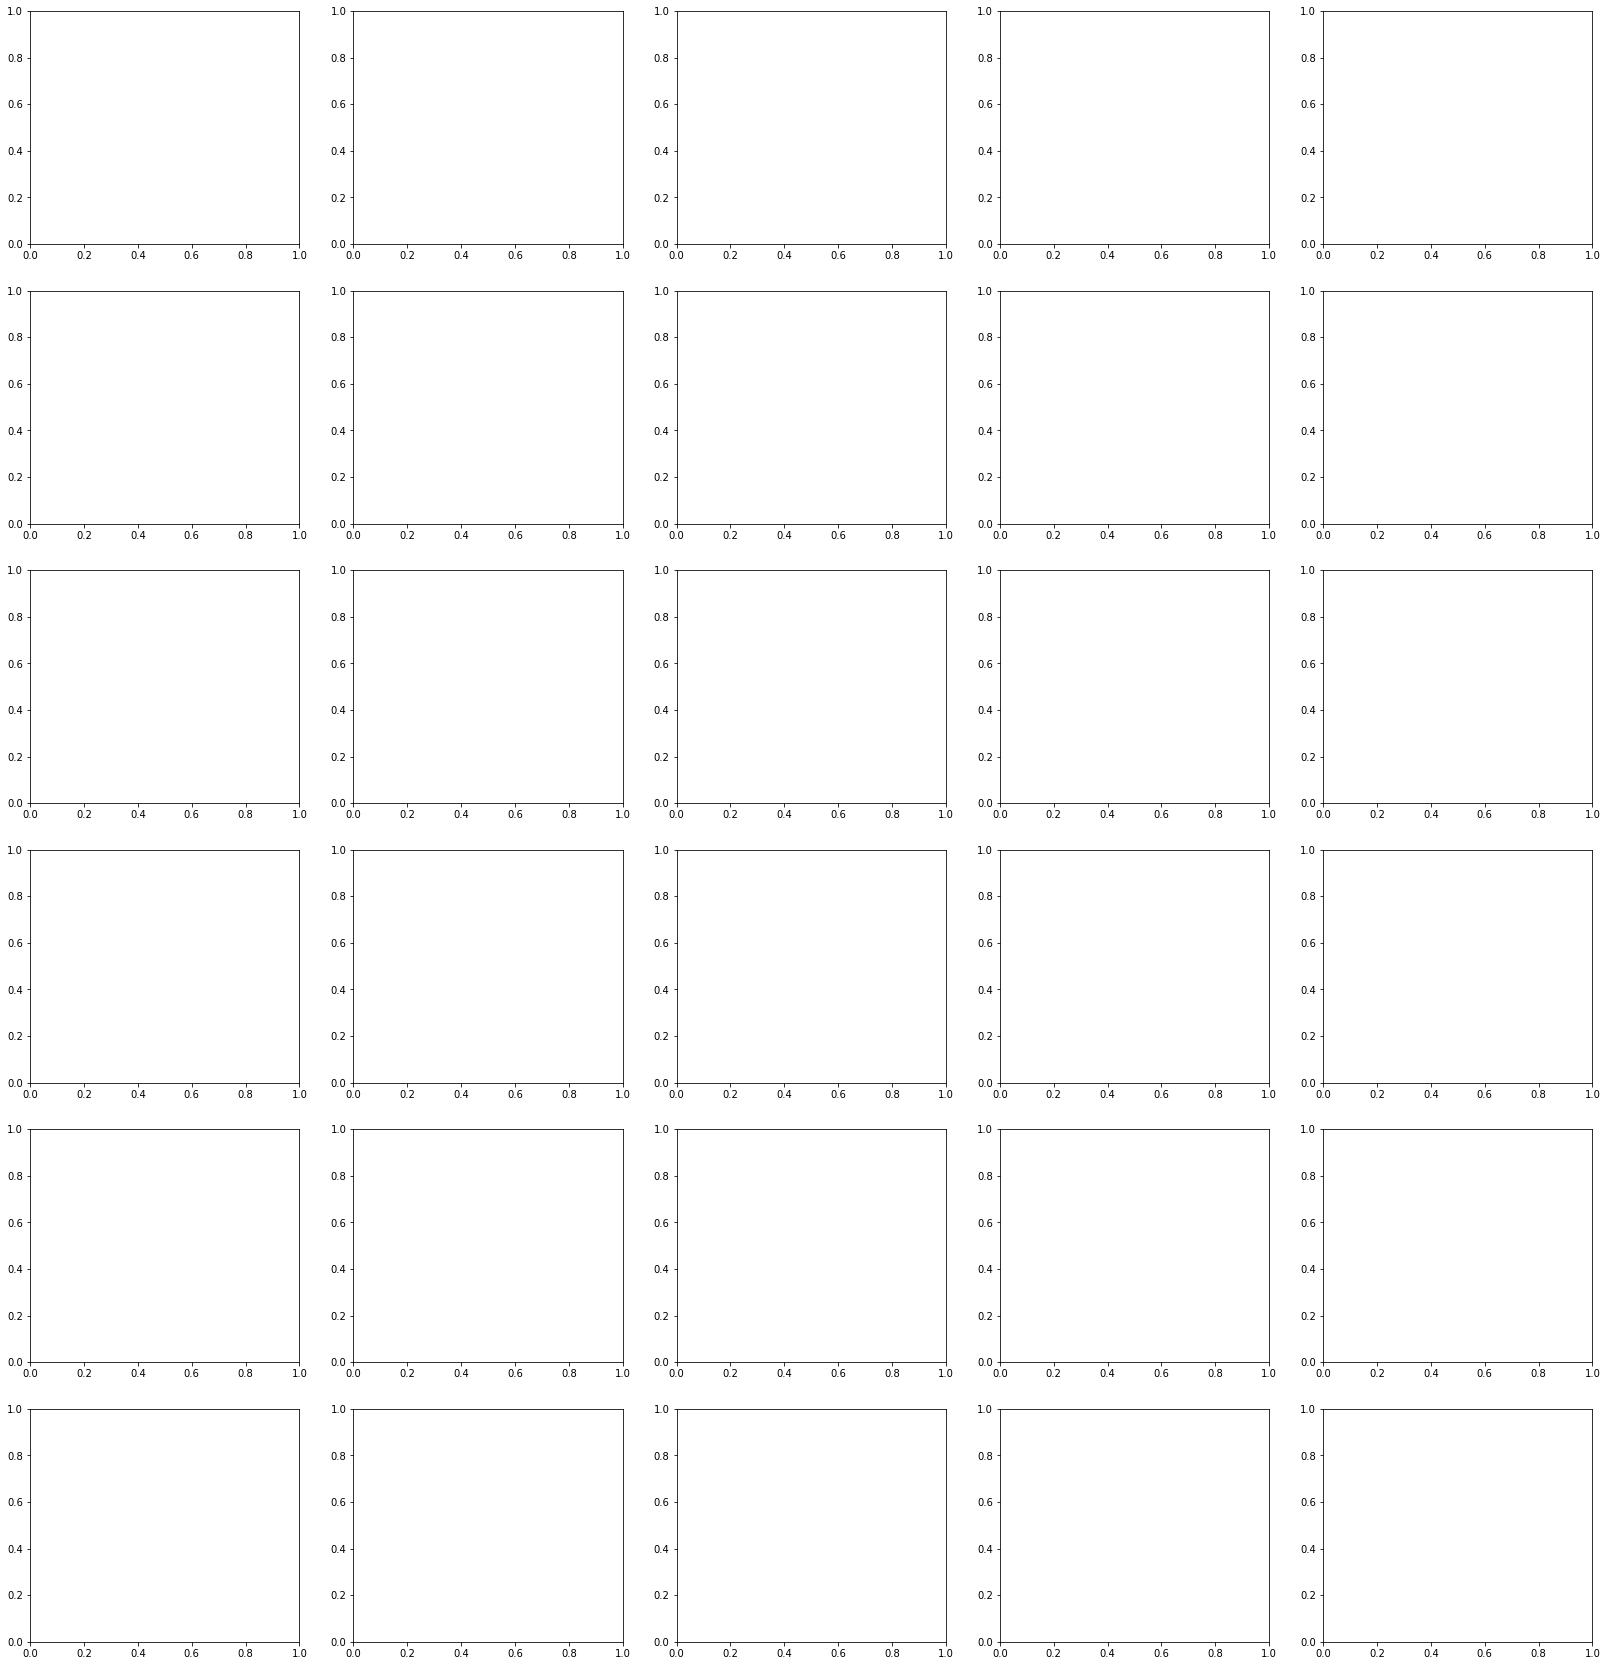

In [13]:
a = 0
while a < 7:
    for i in range(5):
        ls.append((a, i))
    a+=1
fig, ax = plt.subplots(6, 5, figsize=(28, 30))
for k in range(26):
    sns.boxplot(ax=ax[ls[k][0], ls[k][1]], y=colName[k], data=dataVisual)

In [14]:
import plotly.express as px

In [15]:
edadf = df.copy()
edadfsmall = df[0:2467].copy()

#### Appliances vs Light

In [16]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces

fig.add_trace(
    go.Scatter(x=edadfsmall['date'], y=edadfsmall['Appliances'], 
               name="Appliances",
               mode='lines'),
    secondary_y=False,
)



fig.add_trace(
    go.Scatter(x=edadfsmall['date'], y=edadfsmall['lights'], 
               name='lights',
               mode='lines'),
    secondary_y=True,
)

fig.update_layout(
    title='Appliance and Light usage over two weeks',
    xaxis_title="Date")
    
fig.update_yaxes(title_text="Appliance Usage (in Wh)", secondary_y=False, color="blue")
fig.update_yaxes(title_text="Lights Usage (in Wh)", secondary_y=True, color="red")
    
fig.show()

#### Appliances vs Temperature

In [17]:
fig = make_subplots(specs=[[{"secondary_y": True}]])


fig.add_trace(
    go.Scatter(x=edadfsmall['date'], y=edadfsmall['Appliances'], 
               name="Appliances",
               mode='lines'),
    secondary_y=False,
)
tempcolumns = ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T_out']

for i in tempcolumns:
    fig.add_trace(
        go.Scatter(x=edadfsmall['date'], y=edadfsmall[i], 
                   name=i,
                   mode='lines'),
        secondary_y=True,
    )

fig.update_layout(
    title='Appliance usage and Temperature over two weeks',
    xaxis_title="Date")
    
fig.update_yaxes(title_text="Appliance Usage (in Wh)", secondary_y=False, color="blue")
fig.update_yaxes(title_text="Temperature (in Celsius)", secondary_y=True)    
    
fig.show()


In [19]:
from sklearn.model_selection import train_test_split

In [20]:
x_train, x_test,y_train,y_test = train_test_split(X,Y, test_size = 0.25, random_state = 42)

In [21]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)

x_test = scaler.transform(x_test)


In [22]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
from sklearn import neighbors
from sklearn.svm import SVR

In [23]:
models = [
           ['Lasso: ', Lasso()],
           ['Ridge: ', Ridge()],
           ['KNeighborsRegressor: ',  neighbors.KNeighborsRegressor()],
           ['SVR:' , SVR(kernel='rbf')],
           ['RandomForest ',RandomForestRegressor()],
           ['ExtraTreeRegressor :',ExtraTreesRegressor()],
           ['GradientBoostingClassifier: ', GradientBoostingRegressor()] ,
           ['XGBRegressor: ', xgb.XGBRegressor()] ,
           ['MLPRegressor: ', MLPRegressor(  activation='relu', solver='adam',learning_rate='adaptive',max_iter=1000,learning_rate_init=0.01,alpha=0.01)]
         ]

In [27]:
import time
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn import metrics

model_data = []
for name,curr_model in models :
    curr_model_data = {}
    curr_model.random_state = 78
    curr_model_data["Name"] = name
    start = time.time()
    curr_model.fit(x_train, y_train)
    end = time.time()
    curr_model_data["Train_Time"] = end - start
    curr_model_data["Train_R2_Score"] = metrics.r2_score(y_train,curr_model.predict(x_train))
    curr_model_data["Test_R2_Score"] = metrics.r2_score(y_test,curr_model.predict(x_test))
    curr_model_data["Test_RMSE_Score"] = sqrt(mean_squared_error(y_test,curr_model.predict(x_test)))
    model_data.append(curr_model_data)

[13:54:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [28]:
result = pd.DataFrame(model_data)

In [29]:
result

,Name,Train_Time,Train_R2_Score,Test_R2_Score,Test_RMSE_Score
0,Lasso:,0.042968,0.148758,0.143669,92.231634
1,Ridge:,0.020671,0.165889,0.158969,91.403955
2,KNeighborsRegressor:,0.241915,0.578745,0.340387,80.947550
3,SVR:,22.298811,0.018525,0.022151,98.558691
4,RandomForest,39.860270,0.932389,0.517017,69.266761
5,ExtraTreeRegressor :,9.466728,1.000000,0.581470,64.479572
6,GradientBoostingClassifier:,9.475105,0.349350,0.253773,86.098284
7,XGBRegressor:,1.954877,0.343772,0.254225,86.072233
8,MLPRegressor:,35.643715,0.472803,0.332574,81.425555
